# VAE: FC layers

### Setup

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

SEED = 0
# Set seed
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(SEED)

torch.manual_seed(SEED)
np.random.seed(SEED)

# Use GPU if available
GPU = True

if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cpu


In [15]:
# Hyperparameters 
num_epochs = 50
learning_rate = 0.0001
batch_size = 16
latent_dim = 2 
beta = 0.2

# Additional parameters 
input_size = 10
h_dim = 5

### Data loading


In [16]:
df = pd.read_csv('dengue.csv') 

data=["bleeding", "plt", "shock", "haematocrit_percent",
      "bleeding_gum", "abdominal_pain", "ascites", 
      "bleeding_mucosal", "bleeding_skin", "body_temperature"]

info = ["date", "age", "gender", "weight"]

train, test = train_test_split(df, test_size=0.2, random_state=SEED)

train_data = train[data] 
test_data = test[data]
train_info = train[info] 
test_info = test[info]

scaler = preprocessing.MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data.to_numpy()) 
test_scaled = scaler.transform(test_data.to_numpy()) 

loader_train = DataLoader(train_scaled, batch_size, shuffle=True)
loader_test = DataLoader(test_scaled, batch_size, shuffle=False)

-----

### Model

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
  </figcaption>
</figure>


In [28]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, h_dim),
            #nn.ReLU(),

            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, 2 * latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, input_size),
            nn.Sigmoid()
        )

        
    def encode(self, x):
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=1)
        return mu, logvar

    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std) 
        return mu + eps * std

    
    def decode(self, z):   
        return self.decoder(z)
    
    
    def forward(self, x):
        x = x.view(-1, input_size)
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
    

In [29]:
model = VAE(latent_dim).to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 154
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=5, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): Sigmoid()
  )
)


--- 

### Training

Loss function:

$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$


In [30]:
def loss_function_VAE(recon_x, x, mu, logvar, beta):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean') * input_size
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1), dim=0)

    return recon_loss + beta * KLD, recon_loss, KLD


model.train()
train_losses, train_recon, train_KLD = [], [], []
test_losses, test_recon, test_KLD = [], [], []

for epoch in range(num_epochs):     

    train_loss, recon_loss, KL_loss = 0, 0, 0
    
    # TRAIN
    for i, data in enumerate(loader_train):
        model.train()
        data = data.to(device).float()

        out, mu, logvar = model(data)
        loss, recon, KLD = loss_function_VAE(out, data, mu, logvar, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        recon_loss += recon
        KL_loss += KLD

        
    # DISPLAY/SAVE TRAINING LOSSES
    print("TRAIN: \tEpoch {0:2}, Total loss:{1:8.4f}, Recon loss:{2:8.4f}, KL loss:{3:8.4f}".format(
        epoch,
        train_loss / len(loader_train),
        recon_loss / len(loader_train),
        KL_loss / len(loader_train))
    )
    
    train_losses.append(train_loss / len(loader_train))
    train_KLD.append(KL_loss / len(loader_train))
    train_recon.append(recon_loss / len(loader_train))

    
    # DISPLAY/SAVE TESTING LOSSES
    model.eval()
    with torch.no_grad():
        test_loss, test_recon_loss, test_KL_loss = 0, 0, 0
        for i, data in enumerate(loader_test):
            data = data.to(device).float()

            out, mu, logvar = model(data)
            total, recon, KLD = loss_function_VAE(out, data, mu, logvar, beta)

            test_loss += total
            test_KL_loss += KLD
            test_recon_loss += recon
        
        print("TEST: \tEpoch {0:2}, Total loss:{1:8.4f}, Recon loss:{2:8.4f}, KL loss:{3:8.4f}".format(
            epoch,
            test_loss / len(loader_test),
            test_recon_loss / len(loader_test),
            test_KL_loss / len(loader_test))
        )
        
        test_losses.append(test_loss / len(loader_test))
        test_KLD.append(test_KL_loss / len(loader_test))
        test_recon.append(test_recon_loss / len(loader_test))

TRAIN: 	Epoch  0, Total loss:  2.2438, Recon loss:  2.2203, KL loss:  0.1179
TEST: 	Epoch  0, Total loss:  2.1247, Recon loss:  2.1091, KL loss:  0.0779
TRAIN: 	Epoch  1, Total loss:  2.0195, Recon loss:  2.0090, KL loss:  0.0526
TEST: 	Epoch  1, Total loss:  1.9177, Recon loss:  1.9107, KL loss:  0.0349
TRAIN: 	Epoch  2, Total loss:  1.8233, Recon loss:  1.8177, KL loss:  0.0281
TEST: 	Epoch  2, Total loss:  1.7289, Recon loss:  1.7237, KL loss:  0.0262
TRAIN: 	Epoch  3, Total loss:  1.6246, Recon loss:  1.6151, KL loss:  0.0474
TEST: 	Epoch  3, Total loss:  1.5130, Recon loss:  1.4952, KL loss:  0.0894
TRAIN: 	Epoch  4, Total loss:  1.3799, Recon loss:  1.3405, KL loss:  0.1974
TEST: 	Epoch  4, Total loss:  1.2280, Recon loss:  1.1576, KL loss:  0.3520
TRAIN: 	Epoch  5, Total loss:  1.0960, Recon loss:  0.9936, KL loss:  0.5119
TEST: 	Epoch  5, Total loss:  1.0017, Recon loss:  0.8828, KL loss:  0.5945
TRAIN: 	Epoch  6, Total loss:  0.9432, Recon loss:  0.8235, KL loss:  0.5987
TEST:

x-axis: epochs; y-axis: loss; beta=0.2


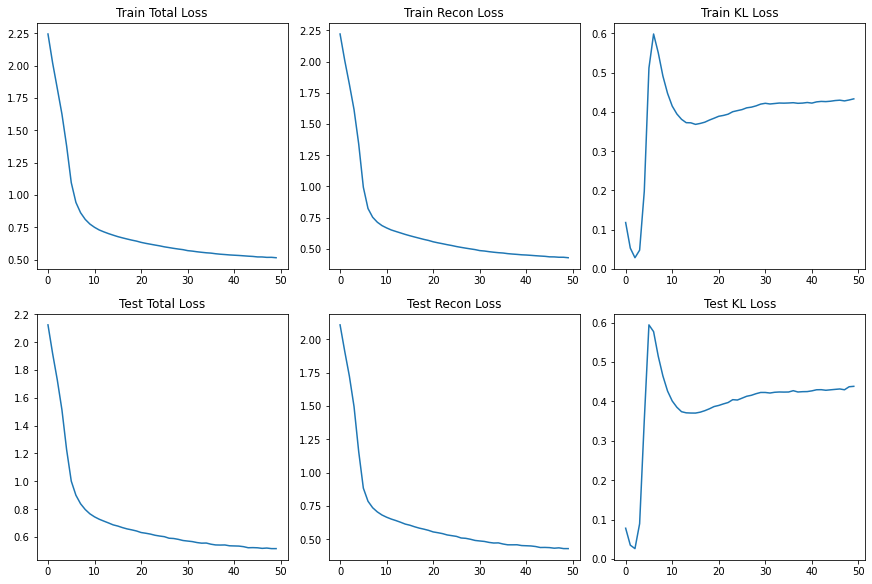

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

print("x-axis: epochs; y-axis: loss; beta={}".format(beta))

fig1 = plt.figure(constrained_layout=True,figsize=(12,8))
spec1 = gridspec.GridSpec(ncols=3, nrows=2, figure=fig1)

f1_ax11 = fig1.add_subplot(spec1[0, 0])
f1_ax11.set_title('Train Total Loss')
f1_ax11.plot(range(num_epochs), train_losses)

f1_ax12 = fig1.add_subplot(spec1[0, 1])
f1_ax12.set_title('Train Recon Loss')
f1_ax12.plot(range(num_epochs), train_recon)

f1_ax13 = fig1.add_subplot(spec1[0, 2])
f1_ax13.set_title('Train KL Loss')
f1_ax13.plot(range(num_epochs), train_KLD)

f1_ax21 = fig1.add_subplot(spec1[1, 0])
f1_ax21.set_title('Test Total Loss')
f1_ax21.plot(range(num_epochs), test_losses)

f1_ax22 = fig1.add_subplot(spec1[1, 1])
f1_ax22.set_title('Test Recon Loss')
f1_ax22.plot(range(num_epochs), test_recon)

f1_ax23 = fig1.add_subplot(spec1[1, 2])
f1_ax23.set_title('Test KL Loss')
f1_ax23.plot(range(num_epochs), test_KLD)

In [32]:
model.eval()
z = []

with torch.no_grad():
    for i, data in enumerate(loader_test):
        mu, logvar = model.encode(data.to(device).float())
        z.append(model.reparametrize(mu, logvar))
        
encoded_inputs = torch.cat(z, dim=0).to("cpu").numpy()

points_x = encoded_inputs[:, 0]
points_y = encoded_inputs[:, 1]

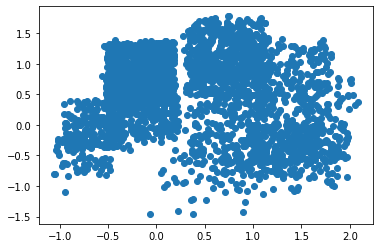

In [33]:
plt.scatter(points_x, points_y)
plt.show()

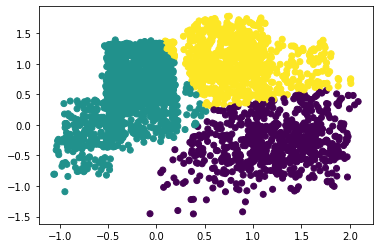

In [37]:
cluster = KMeans(n_clusters=3, random_state=SEED).fit_predict(encoded_inputs)

plt.scatter(points_x, points_y, c=cluster)
plt.show()

c:\users\oliver\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


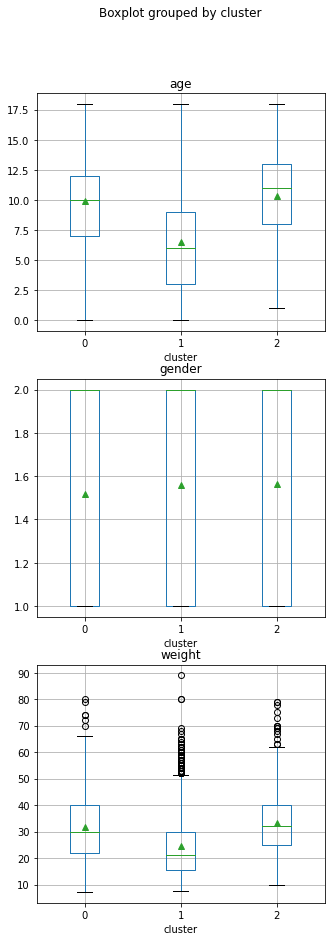

In [38]:
test_info['cluster'] = cluster

_, ax0 = plt.subplots(3, 1, figsize=(5, 15))
test_info.boxplot('age','cluster', ax=ax0[0], showmeans=True)
test_info.boxplot('gender','cluster', ax=ax0[1], showmeans=True)
test_info.boxplot('weight','cluster', ax=ax0[2], showmeans=True)
plt.show()

c:\users\oliver\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


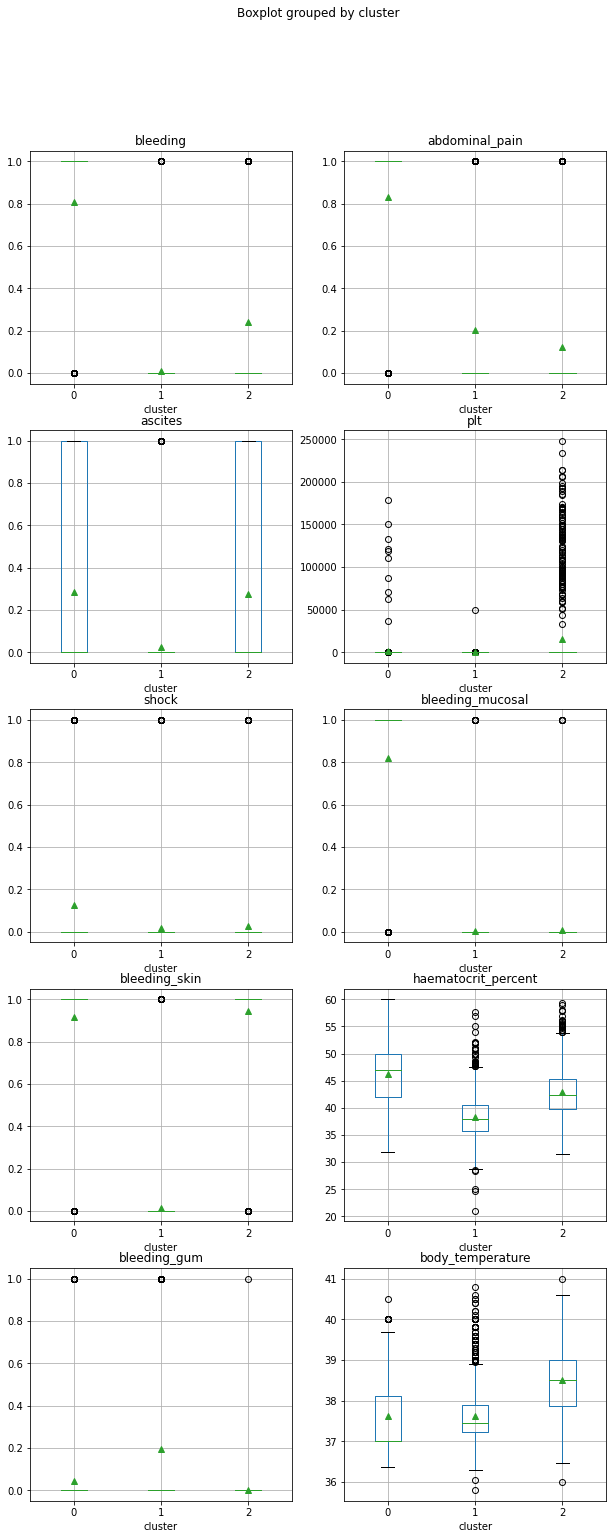

In [39]:
test_data['cluster'] = cluster

_, ax1 = plt.subplots(5, 2, figsize=(10, 25))

features = ["bleeding", "plt", "shock", "haematocrit_percent", "bleeding_gum",
            "abdominal_pain", "ascites", "bleeding_mucosal", "bleeding_skin",
            "body_temperature"]

for i, feat in enumerate(features):
    test_data.boxplot(feat,'cluster', ax=ax1[i%5][i%2], showmeans=True)

plt.show()